In [62]:
import math
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

!nvidia-smi

Mon Jun 19 15:19:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:15:00.0 Off |                    0 |
| N/A   26C    P0    52W / 300W |   1976MiB / 32768MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [63]:
# Dispositivo onde tensores serão criados, armazenados e processados
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Randon Seed fixa para resultados reprodutíveis
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

cuda:0


## Data Loader

In [64]:
class WellLoader(Dataset):
    
    def __init__(self, 
                 path, 
                 wells, 
                 var_in, 
                 var_out,
                 normalizing_percentile=90.0,
                 normalizing_split=0.2,
                 normalizer=RobustScaler,
                 max_sequence=16, 
                 step=1):
        
        self.path = path
        with open(self.path + '/metadata.json', 'r') as metafile:
            self.metadata = json.loads(metafile.read())
        self.wells = wells
        self.var_in = var_in
        self.var_out = var_out
        self.normalizing_percentile=normalizing_percentile
        self.normalizing_split = normalizing_split
        self.normalizer = normalizer
        self.max_sequence = max_sequence
        self.step = step
        self.batches_X = None
        self.batches_Y = None
        self.outputs = None
        self.normalizers = []
        
        indexes = self.get_wells_index(self.wells)
        self.load_data_by_index(indexes)
        
    def get_wells_index(self, wells):
        
        indexes = []
        for well, filt in wells:
            indexes.extend([(meta['INDEX'], filt) for meta in self.metadata if meta['WELL'] == well])
        return indexes
    
    def load_data_by_index(self, indexes):
        
        batches_X = []
        batches_Y = []
        outputs = []
        for index, filt in indexes:
            data = pd.read_json(f'{self.path}/{index}.json')#.reset_index()
            # Armengue: Por liq vol para preencher o dataset
            data['BORE_LIQ_VOL'] = data['BORE_OIL_VOL'] + data['BORE_WAT_VOL']
            data = data[self.var_in + self.var_out].dropna().reset_index(drop=True)
            X = data.values[filt,:]
            Y = data[self.var_out].values[filt,:]
            X_base, _, Y_base, _ = train_test_split(X, Y, test_size = self.normalizing_split)
            #scaler_X = X_base.max(axis=0, keepdims=True)
            #scaler_Y = Y_base.max(axis=0, keepdims=True)
            #scaler_X = self.normalizer().fit(X_base)
            #scaler_Y = self.normalizer().fit(Y_base)
            scaler_X = np.percentile(X_base,self.normalizing_percentile,axis=0,keepdims=True)
            scaler_Y = np.percentile(Y_base,self.normalizing_percentile,axis=0,keepdims=True)
            self.normalizers.append((scaler_X, scaler_Y))
            #X, Y = scaler_X.transform(X), scaler_Y.transform(Y)
            X, Y = X / scaler_X, Y / scaler_Y
            X, Y = torch.from_numpy(X.astype('float32')), torch.from_numpy(Y.astype('float32'))
            output = Y[self.max_sequence::self.step]
            #print(Y.shape)
            #X = torch.split(X, self.max_sequence, dim= 0)
            #Y = torch.split(Y, self.max_sequence, dim= 0)
            X = X.unfold(0,self.max_sequence, self.step)
            Y = Y.unfold(0,self.max_sequence, self.step)
            batches_X.append(X[:-1,:,:])
            batches_Y.append(Y[:-1,:,:])
            outputs.append(Y[1:,:,:])
            #print(X.shape)
        self.batches_X = torch.concat(batches_X, axis=0)
        self.batches_Y = torch.concat(batches_Y, axis=0)
        self.outputs = torch.concat(outputs, axis=0)
            
    def __len__(self):
        
        return self.outputs.shape[0]
    
    def __getitem__(self, idx):
                        
        srcs = self.batches_X[idx,:,:]
        trgts = self.batches_Y[idx,:,:]
        output = self.outputs[idx,:,:]
        
        return srcs.permute(1,0), trgts.permute(1,0), output.permute(1,0)
        
        
                 

In [65]:
path = './dataset/volve'
wells = [
    ('15/9-F-1 C', slice(28, None)),
]

var_in = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        'AVG_CHOKE_SIZE_P',
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

var_out = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
]

dataset = WellLoader(path, wells, var_in, var_out, max_sequence = 16)

In [66]:
print(dataset[0])

(tensor([[0.7839, 0.6474, 0.8411, 0.7933, 0.9954, 0.8104],
        [0.7913, 0.6511, 0.5181, 0.7699, 0.9934, 0.1569],
        [0.7852, 0.6506, 0.8560, 0.7895, 0.9942, 0.8370],
        [0.7819, 0.6418, 0.8446, 0.7984, 0.9956, 0.7297],
        [0.7851, 0.6445, 0.8347, 0.7827, 0.9950, 0.6819],
        [0.7882, 0.6454, 0.8240, 0.7465, 0.9945, 0.6570],
        [0.7836, 0.6366, 0.8032, 0.7567, 0.9947, 0.6322],
        [0.7847, 0.6338, 0.8237, 0.6687, 0.9944, 0.6597],
        [0.7840, 0.6295, 0.8242, 0.6657, 0.9944, 0.6526],
        [0.7767, 0.6172, 0.8374, 0.7419, 0.9950, 0.6943],
        [0.7645, 0.6002, 0.8495, 0.7407, 0.9961, 0.7404],
        [0.7659, 0.5994, 0.8383, 0.7672, 0.9958, 0.6996],
        [0.7647, 0.5957, 0.8384, 0.7654, 0.9958, 0.6943],
        [0.7644, 0.5937, 0.8274, 0.7188, 0.9957, 0.6597],
        [0.7641, 0.5913, 0.8232, 0.7384, 0.9957, 0.6517],
        [0.7637, 0.5900, 0.8231, 0.6750, 0.9959, 0.7413]]), tensor([[0.8104],
        [0.1569],
        [0.8370],
        [0.7297

In [67]:
class SubsetSplitter:
    
    def __init__(self, batch_size, validation_split, test_split, shuffle=False):
        
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.test_split = test_split
        self.shuffle = shuffle
        
    def __call__(self, dataset:Dataset):
        
        dataset_size = len(dataset)
        indices = list(range(dataset_size))
        validation_split = int(np.floor(self.validation_split * dataset_size))
        test_split = int(np.floor(self.test_split * dataset_size))
        train_split = dataset_size - validation_split - test_split
        # Extracting test independently of others
        test_indices = indices[train_split + validation_split:]
        indices = indices[:train_split + validation_split]
        if self.shuffle :
            np.random.shuffle(indices)
        train_indices = indices[:train_split]
        validation_indices = indices[train_split:]

        # Creating PT data samplers and loaders:
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(validation_indices)
        test_sampler = SubsetRandomSampler(test_indices)

        train_loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, 
                                                   sampler=train_sampler)
        validation_loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size,
                                                    sampler=valid_sampler)
        test_loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size,
                                                    sampler=test_sampler)
        
        return train_loader, validation_loader, test_loader

In [68]:
splitter = SubsetSplitter(4, 0.1, 0.3, shuffle=False)
train_loader, validation_loader, test_loader = splitter(dataset)

## Model definition

In [69]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])
    
    
positional_encoding = PositionalEncoding(dim_model = 10, dropout_p=0.3, max_len=1200)
tensor = torch.zeros((1,2,10))
tensor
encoded = positional_encoding(tensor)
encoded

tensor([[[0.0000, 0.0000, 0.0000, 1.4286, 0.0000, 1.4286, 0.0000, 1.4286,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.4286, 0.0000, 0.0000,
          0.0000, 1.4286]]])

In [70]:
class TSTransformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    # Constructor
    def __init__(
        self,
        num_outputs,
        src_dim,
        tgt_dim,
        src_heads,
        tgt_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
        dim_feedforward =2048,
        num_linear_layers=0,
        norm_first=False
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.src_dim = src_dim
        self.tgt_dim = tgt_dim

        # LAYERS
        
        # MONTANDO O TRANSFORMER
        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=src_dim,
            nhead=src_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout_p,
            batch_first=True,
            norm_first=norm_first
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer = encoder_layer,
            num_layers = num_encoder_layers,
            norm=None,
        )
        
        # Decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=tgt_dim,
            nhead=tgt_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout_p,
            batch_first=True,
            norm_first=norm_first
        )
        self.decoder = nn.TransformerDecoder(
            decoder_layer = decoder_layer,
            num_layers = num_decoder_layers,
            norm=None,
        )
            
        # Como encoder e decoder podem ter dimenoes
        self.memory_match = nn.Linear(src_dim, tgt_dim)
        
        self.linear_layers = nn.ModuleList()
        for i in range(num_linear_layers):
            self.linear_layers.append(nn.Linear(dim_model, dim_model))
            self.linear_layers.append(nn.ReLU6())
        self.out = nn.Linear(tgt_dim, num_outputs)
        
        
    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None, is_causal=False):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)
        
        
        

        # Step1 - Passing source through encoder
        memory = self.encoder(src, 
                              mask=src_mask,
                              src_key_padding_mask=src_pad_mask,
                              is_causal=is_causal)
        
        # Step2 - Matching memory sahpe to tgt shape
        memory = self.memory_match(memory)
        
        
        # Step3 - Passing tgt and memory through decoder
        transformer_out = memory
        #transformer_out = self.decoder(tgt, 
        #                               memory,
        #                               tgt_mask=tgt_mask,
        #                               memory_mask=src_mask,
        #                               tgt_key_padding_mask=tgt_pad_mask,
        #                               memory_key_padding_mask=src_pad_mask,
        #                              )
        
        
        for linear in self.linear_layers:
            transformer_out = linear(transformer_out)
        out = transformer_out
        #out = torch.add(out, tgt)
        #out = torch.concat([out, tgt], axis=-1)
        
        #recuperando informacao de escala
        #out = torch.mul(out, tgt)
        #bias = self.bias_layer(tgt)
        #out = torch.add(out, bias)
        #out = self.out(out)
        
        
        return out
      
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0,float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1,float(0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return (matrix == pad_token)

In [71]:
class Training:
    
    def __init__(self, epochs, loss, optimizer, scheduler, path, model_name='Transformer', model_size=8, early_stop=True, patience=5):
        
        self.loss = loss
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.epochs = epochs
        self.path = path
        self.model_name = model_name
        self.model_size = model_size
        self.early_stop_flag = early_stop
        self.patience = patience
        self.clear_results()
        
    def clear_results(self):
        
        self.results = {
            'Train':[],
            'Validation':[],
            'Test':[],
        }
        
    def fit(self, model, train_loader, validation_loader, test_loader):
        
        self.clear_results()
        torch.cuda.empty_cache()
        decrease = self.patience
        not_improved = 0
        
        model.to(device)
        fit_time = time.time()
        
        for e in range(self.epochs):
            since = time.time()
            running_loss = 0
            #training loop
            model.train()
            self.train_loop(model, train_loader)
            model.eval()
            self.validation_loop(model, validation_loader)
            self.test_loop(model, test_loader)
            decrease, not_improved = self.early_stopping(validation_loader, decrease)
            if not_improved == 1 and self.early_stop_flag:
                print('[***] end training ...') 
                break
            loss_per_training_batch = self.results['Train'][-1]
            loss_per_validation_batch = self.results['Validation'][-1]
            loss_per_test_batch = self.results['Test'][-1]
            print("Epoch:{}/{}..".format(e+1, self.epochs),
                  "Train Loss: {:.3f}..".format(loss_per_training_batch),
                  "Val Loss: {:.3f}..".format(loss_per_validation_batch),
                  "Test Loss: {:.3f}..".format(loss_per_test_batch),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
        
    def train_loop(self, model, train_loader):
        
        mask = model.get_tgt_mask(self.model_size).to(device)
        running_loss = 0.0
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            X, y_tgt, y_out = data
            X, y_tgt, y_out = X.to(device), y_tgt.to(device), y_out.to(device)
            
            output = model(X, y_tgt, src_mask=mask, tgt_mask=mask)
            #print(X.shape, y_tgt.shape, y_out.shape, output.shape)
            loss = self.loss(output, y_out)
            #backward
            loss.backward()
            self.optimizer.step() #update weight          
            self.optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            if not self.scheduler is None:
                self.scheduler.step()
            running_loss += loss.item()
        
        self.results['Train'].append(running_loss/len(train_loader))
    
    
    def validation_loop(self, model, validation_loader):
        
        mask = model.get_tgt_mask(self.model_size).to(device)
        running_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(tqdm(validation_loader)):
                #training phase
                X, y_tgt, y_out = data
                X, y_tgt, y_out = X.to(device), y_tgt.to(device), y_out.to(device)
                
                output = model(X, y_tgt, src_mask=mask, tgt_mask=mask)
                loss = self.loss(output, y_out)
                
                running_loss += loss.item()
        
        self.results['Validation'].append(running_loss/len(validation_loader))
        
    def test_loop(self, model, test_loader):
        
        mask = model.get_tgt_mask(self.model_size).to(device)
        running_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(tqdm(test_loader)):
                #training phase
                X, y_tgt, y_out = data
                X, y_tgt, y_out = X.to(device), y_tgt.to(device), y_out.to(device)
                
                output = model(X, y_tgt, src_mask=mask, tgt_mask=mask)
                loss = self.loss(output, y_out)
                
                running_loss += loss.item()
        
        self.results['Test'].append(running_loss/len(test_loader))
        
    def early_stopping(self, validation_loader, decrease):
        
        loss_per_validation_batch = self.results['Validation'][-1]
        min_loss = np.min(self.results['Validation'][:-1] + [np.inf])
        if min_loss >= self.results['Validation'][-1]:
            print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, loss_per_validation_batch))
            decrease = self.patience
            print('saving model...')
            torch.save(model, self.path + f'/{self.model_name}.pt')
        else:
            decrease -= 1
        if decrease < 0:     
                not_improved = 1
        else:
            not_improved = 0
        return decrease, not_improved
    
    def get_best_model(self):
        
        model = torch.load(self.path + f'/{self.model_name}.pt')
        return model
            
            

In [72]:
model = TSTransformer(
    num_outputs=1,
    src_dim=6,
    tgt_dim=1,
    src_heads=1,
    tgt_heads=1,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dropout_p=0.1,
    dim_feedforward =24,
    num_linear_layers=0,
    norm_first=False,
).to(device)

print(model)

lr_ = 5e-4
epoch = 1000
weight_decay = 1e-4
path = '.'
model_name = 'TRANSPOSED-SIMP'

loss = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=lr_)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr_)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_, weight_decay=weight_decay)
sched = None
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr_, epochs=epoch,
                                            steps_per_epoch=len(train_loader))
training = Training(epoch, loss, optimizer, sched, model_name=model_name, model_size = dataset.max_sequence, path=path, early_stop=True, patience=20)

TSTransformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
        )
        (linear1): Linear(in_features=6, out_features=24, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=24, out_features=6, bias=True)
        (norm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1, out_features=1, bias=True)
        )
        (multihead_attn): MultiheadAttention(


In [73]:
training.fit(model, train_loader, validation_loader, test_loader)
best_model = training.get_best_model()

  0%|          | 0/18 [00:00<?, ?it/s]/projetos/c5ef/venvs/dl_raul/lib64/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
100%|██████████| 53/53 [00:00<00:00, 570.42it/s]


Loss Decreasing.. inf >> 0.287 
saving model...
Epoch:1/1000.. Train Loss: 0.295.. Val Loss: 0.287.. Test Loss: 0.256.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 538.28it/s]


Loss Decreasing.. 0.287 >> 0.236 
saving model...
Epoch:2/1000.. Train Loss: 0.226.. Val Loss: 0.236.. Test Loss: 0.210.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 565.06it/s]


Loss Decreasing.. 0.236 >> 0.218 
saving model...
Epoch:3/1000.. Train Loss: 0.181.. Val Loss: 0.218.. Test Loss: 0.181.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 567.64it/s]


Loss Decreasing.. 0.218 >> 0.190 
saving model...
Epoch:4/1000.. Train Loss: 0.161.. Val Loss: 0.190.. Test Loss: 0.167.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 558.73it/s]


Loss Decreasing.. 0.190 >> 0.170 
saving model...
Epoch:5/1000.. Train Loss: 0.148.. Val Loss: 0.170.. Test Loss: 0.152.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 529.55it/s]


Loss Decreasing.. 0.170 >> 0.152 
saving model...
Epoch:6/1000.. Train Loss: 0.135.. Val Loss: 0.152.. Test Loss: 0.140.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 548.06it/s]


Loss Decreasing.. 0.152 >> 0.142 
saving model...
Epoch:7/1000.. Train Loss: 0.125.. Val Loss: 0.142.. Test Loss: 0.131.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 583.78it/s]


Epoch:8/1000.. Train Loss: 0.117.. Val Loss: 0.145.. Test Loss: 0.121.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 558.68it/s]


Loss Decreasing.. 0.142 >> 0.139 
saving model...
Epoch:9/1000.. Train Loss: 0.109.. Val Loss: 0.139.. Test Loss: 0.114.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 520.37it/s]


Loss Decreasing.. 0.139 >> 0.120 
saving model...
Epoch:10/1000.. Train Loss: 0.105.. Val Loss: 0.120.. Test Loss: 0.108.. Time: 0.02m


100%|██████████| 53/53 [00:00<00:00, 511.01it/s]


Epoch:11/1000.. Train Loss: 0.097.. Val Loss: 0.120.. Test Loss: 0.103.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 517.82it/s]


Loss Decreasing.. 0.120 >> 0.116 
saving model...
Epoch:12/1000.. Train Loss: 0.093.. Val Loss: 0.116.. Test Loss: 0.097.. Time: 0.02m


100%|██████████| 53/53 [00:00<00:00, 567.14it/s]


Loss Decreasing.. 0.116 >> 0.108 
saving model...
Epoch:13/1000.. Train Loss: 0.089.. Val Loss: 0.108.. Test Loss: 0.091.. Time: 0.02m


100%|██████████| 53/53 [00:00<00:00, 531.09it/s]


Epoch:14/1000.. Train Loss: 0.083.. Val Loss: 0.111.. Test Loss: 0.087.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 547.27it/s]


Loss Decreasing.. 0.108 >> 0.100 
saving model...
Epoch:15/1000.. Train Loss: 0.083.. Val Loss: 0.100.. Test Loss: 0.083.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 522.59it/s]


Epoch:16/1000.. Train Loss: 0.077.. Val Loss: 0.103.. Test Loss: 0.081.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 555.46it/s]


Loss Decreasing.. 0.100 >> 0.100 
saving model...
Epoch:17/1000.. Train Loss: 0.075.. Val Loss: 0.100.. Test Loss: 0.077.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 552.05it/s]


Loss Decreasing.. 0.100 >> 0.090 
saving model...
Epoch:18/1000.. Train Loss: 0.071.. Val Loss: 0.090.. Test Loss: 0.074.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 441.10it/s]


Loss Decreasing.. 0.090 >> 0.086 
saving model...
Epoch:19/1000.. Train Loss: 0.070.. Val Loss: 0.086.. Test Loss: 0.071.. Time: 0.02m


100%|██████████| 53/53 [00:00<00:00, 546.43it/s]


Epoch:20/1000.. Train Loss: 0.066.. Val Loss: 0.089.. Test Loss: 0.068.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 561.52it/s]


Loss Decreasing.. 0.086 >> 0.085 
saving model...
Epoch:21/1000.. Train Loss: 0.065.. Val Loss: 0.085.. Test Loss: 0.066.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 542.15it/s]


Loss Decreasing.. 0.085 >> 0.080 
saving model...
Epoch:22/1000.. Train Loss: 0.061.. Val Loss: 0.080.. Test Loss: 0.065.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 530.77it/s]


Epoch:23/1000.. Train Loss: 0.060.. Val Loss: 0.081.. Test Loss: 0.062.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 533.15it/s]


Loss Decreasing.. 0.080 >> 0.078 
saving model...
Epoch:24/1000.. Train Loss: 0.061.. Val Loss: 0.078.. Test Loss: 0.061.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 535.75it/s]


Loss Decreasing.. 0.078 >> 0.076 
saving model...
Epoch:25/1000.. Train Loss: 0.058.. Val Loss: 0.076.. Test Loss: 0.060.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 554.95it/s]


Epoch:26/1000.. Train Loss: 0.055.. Val Loss: 0.078.. Test Loss: 0.059.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 539.69it/s]


Epoch:27/1000.. Train Loss: 0.056.. Val Loss: 0.081.. Test Loss: 0.058.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 553.24it/s]


Epoch:28/1000.. Train Loss: 0.054.. Val Loss: 0.076.. Test Loss: 0.056.. Time: 0.02m


100%|██████████| 53/53 [00:00<00:00, 553.97it/s]


Loss Decreasing.. 0.076 >> 0.074 
saving model...
Epoch:29/1000.. Train Loss: 0.055.. Val Loss: 0.074.. Test Loss: 0.056.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 548.38it/s]


Loss Decreasing.. 0.074 >> 0.073 
saving model...
Epoch:30/1000.. Train Loss: 0.052.. Val Loss: 0.073.. Test Loss: 0.055.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 581.15it/s]


Epoch:31/1000.. Train Loss: 0.051.. Val Loss: 0.076.. Test Loss: 0.054.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 548.98it/s]


Epoch:32/1000.. Train Loss: 0.050.. Val Loss: 0.073.. Test Loss: 0.053.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 546.15it/s]


Loss Decreasing.. 0.073 >> 0.069 
saving model...
Epoch:33/1000.. Train Loss: 0.050.. Val Loss: 0.069.. Test Loss: 0.052.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 546.04it/s]


Loss Decreasing.. 0.069 >> 0.068 
saving model...
Epoch:34/1000.. Train Loss: 0.049.. Val Loss: 0.068.. Test Loss: 0.052.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 550.56it/s]


Loss Decreasing.. 0.068 >> 0.068 
saving model...
Epoch:35/1000.. Train Loss: 0.048.. Val Loss: 0.068.. Test Loss: 0.051.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 544.58it/s]


Epoch:36/1000.. Train Loss: 0.048.. Val Loss: 0.073.. Test Loss: 0.051.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 557.25it/s]


Loss Decreasing.. 0.068 >> 0.067 
saving model...
Epoch:37/1000.. Train Loss: 0.046.. Val Loss: 0.067.. Test Loss: 0.051.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 558.96it/s]


Epoch:38/1000.. Train Loss: 0.045.. Val Loss: 0.067.. Test Loss: 0.049.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 563.12it/s]


Epoch:39/1000.. Train Loss: 0.046.. Val Loss: 0.074.. Test Loss: 0.050.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 548.40it/s]


Epoch:40/1000.. Train Loss: 0.045.. Val Loss: 0.069.. Test Loss: 0.050.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 537.29it/s]


Loss Decreasing.. 0.067 >> 0.066 
saving model...
Epoch:41/1000.. Train Loss: 0.044.. Val Loss: 0.066.. Test Loss: 0.049.. Time: 0.02m


100%|██████████| 53/53 [00:00<00:00, 536.65it/s]


Epoch:42/1000.. Train Loss: 0.043.. Val Loss: 0.071.. Test Loss: 0.050.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 553.84it/s]


Epoch:43/1000.. Train Loss: 0.043.. Val Loss: 0.069.. Test Loss: 0.048.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 561.24it/s]


Epoch:44/1000.. Train Loss: 0.043.. Val Loss: 0.071.. Test Loss: 0.048.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 553.56it/s]


Loss Decreasing.. 0.066 >> 0.065 
saving model...
Epoch:45/1000.. Train Loss: 0.042.. Val Loss: 0.065.. Test Loss: 0.049.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 549.76it/s]


Epoch:46/1000.. Train Loss: 0.043.. Val Loss: 0.070.. Test Loss: 0.048.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 523.99it/s]


Loss Decreasing.. 0.065 >> 0.064 
saving model...
Epoch:47/1000.. Train Loss: 0.042.. Val Loss: 0.064.. Test Loss: 0.048.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 518.21it/s]


Epoch:48/1000.. Train Loss: 0.042.. Val Loss: 0.068.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 534.22it/s]


Epoch:49/1000.. Train Loss: 0.041.. Val Loss: 0.065.. Test Loss: 0.048.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 459.38it/s]


Epoch:50/1000.. Train Loss: 0.042.. Val Loss: 0.069.. Test Loss: 0.047.. Time: 0.02m


100%|██████████| 53/53 [00:00<00:00, 552.34it/s]


Epoch:51/1000.. Train Loss: 0.040.. Val Loss: 0.069.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 561.36it/s]


Epoch:52/1000.. Train Loss: 0.040.. Val Loss: 0.068.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 554.40it/s]


Epoch:53/1000.. Train Loss: 0.039.. Val Loss: 0.071.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 565.39it/s]


Loss Decreasing.. 0.064 >> 0.064 
saving model...
Epoch:54/1000.. Train Loss: 0.039.. Val Loss: 0.064.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 546.94it/s]


Epoch:55/1000.. Train Loss: 0.039.. Val Loss: 0.068.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 558.10it/s]


Epoch:56/1000.. Train Loss: 0.039.. Val Loss: 0.064.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 542.10it/s]


Loss Decreasing.. 0.064 >> 0.063 
saving model...
Epoch:57/1000.. Train Loss: 0.038.. Val Loss: 0.063.. Test Loss: 0.046.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 551.14it/s]


Epoch:58/1000.. Train Loss: 0.038.. Val Loss: 0.067.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 558.10it/s]


Epoch:59/1000.. Train Loss: 0.037.. Val Loss: 0.064.. Test Loss: 0.046.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 541.25it/s]


Epoch:60/1000.. Train Loss: 0.037.. Val Loss: 0.065.. Test Loss: 0.047.. Time: 0.02m


100%|██████████| 53/53 [00:00<00:00, 546.29it/s]


Epoch:61/1000.. Train Loss: 0.037.. Val Loss: 0.064.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 557.39it/s]


Epoch:62/1000.. Train Loss: 0.037.. Val Loss: 0.063.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 562.67it/s]


Epoch:63/1000.. Train Loss: 0.037.. Val Loss: 0.065.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 549.35it/s]


Epoch:64/1000.. Train Loss: 0.036.. Val Loss: 0.067.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 551.33it/s]


Epoch:65/1000.. Train Loss: 0.036.. Val Loss: 0.068.. Test Loss: 0.048.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 543.02it/s]


Epoch:66/1000.. Train Loss: 0.036.. Val Loss: 0.065.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 561.47it/s]


Epoch:67/1000.. Train Loss: 0.036.. Val Loss: 0.068.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 573.09it/s]


Epoch:68/1000.. Train Loss: 0.035.. Val Loss: 0.070.. Test Loss: 0.046.. Time: 0.02m


100%|██████████| 53/53 [00:00<00:00, 555.76it/s]


Epoch:69/1000.. Train Loss: 0.035.. Val Loss: 0.064.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 522.57it/s]


Epoch:70/1000.. Train Loss: 0.034.. Val Loss: 0.064.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 549.53it/s]


Epoch:71/1000.. Train Loss: 0.034.. Val Loss: 0.064.. Test Loss: 0.046.. Time: 0.02m


100%|██████████| 53/53 [00:00<00:00, 554.22it/s]


Epoch:72/1000.. Train Loss: 0.034.. Val Loss: 0.068.. Test Loss: 0.046.. Time: 0.02m


100%|██████████| 53/53 [00:00<00:00, 558.86it/s]


Epoch:73/1000.. Train Loss: 0.034.. Val Loss: 0.066.. Test Loss: 0.046.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 553.44it/s]


Epoch:74/1000.. Train Loss: 0.034.. Val Loss: 0.064.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 553.61it/s]


Epoch:75/1000.. Train Loss: 0.033.. Val Loss: 0.069.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 543.45it/s]


Epoch:76/1000.. Train Loss: 0.034.. Val Loss: 0.068.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 548.56it/s]


Epoch:77/1000.. Train Loss: 0.034.. Val Loss: 0.068.. Test Loss: 0.047.. Time: 0.01m


100%|██████████| 53/53 [00:00<00:00, 557.41it/s]


[***] end training ...
Total time: 1.13 m


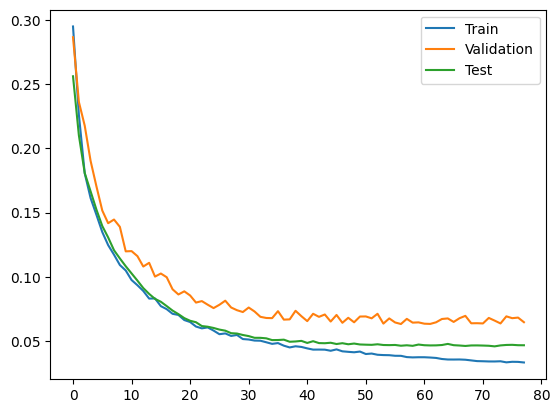

In [74]:
fig, ax = plt.subplots()

ax.plot(training.results['Train'], label='Train')
ax.plot(training.results['Validation'], label='Validation')
ax.plot(training.results['Test'], label='Test')
ax.legend()

## Evaluation and plotting classes

In [75]:
class OSAEvaluator:
    
    def evaluate_OSA(self, dataset, model):
        
        torch.cuda.empty_cache()
        Y_real = []
        Y_pred = []
        for i, data in enumerate(tqdm(dataset)):
            src, tgt, y_real = data
            src, tgt, y_real = src.to(device), tgt.to(device), y_real.to(device)
            y_pred = model(src, tgt)
            Y_real.append(y_real[-1,:])
            Y_pred.append(y_pred[-1,:])
        
        Y_real = torch.vstack(Y_real).cpu()
        Y_pred = torch.vstack(Y_pred).cpu().detach()
        print('********** OSA Evaluation summary **********')
        print(f'OSA MSE: {mean_squared_error(Y_real, Y_pred)}')
        print(f'OSA RMSE: {np.sqrt(mean_squared_error(Y_real, Y_pred))}')
        print(f'OSA R2 score: {r2_score(Y_real, Y_pred)}')
        print('********************************************')
        return Y_real, Y_pred
            
class FSEvaluator:
    
    def evaluate_FS(self, dataset, model):
        
        torch.cuda.empty_cache()
        Y_real = []
        Y_pred = []
        tgt_sim = None
        for i, data in enumerate(tqdm(dataset)):
            src, tgt, y_real = data
            src, tgt, y_real = src.to(device), tgt.to(device), y_real.to(device)
            if tgt_sim is None:
                tgt_sim = tgt
            y_pred = model(src, tgt_sim)
            tgt_sim[:-1,:] = tgt_sim[1:,:].clone()
            tgt_sim[-1,:] = y_pred[-1,:].clone()
            Y_real.append(y_real[-1,:])
            Y_pred.append(y_pred[-1,:])
        
        Y_real = torch.vstack(Y_real).cpu()
        Y_pred = torch.vstack(Y_pred).cpu().detach()
        print('*********** FS Evaluation summary **********')
        print(f'FS MSE: {mean_squared_error(Y_real, Y_pred)}')
        print(f'FS RMSE: {np.sqrt(mean_squared_error(Y_real, Y_pred))}')
        print(f'FS R2 score: {r2_score(Y_real, Y_pred)}')
        print('********************************************')
        return Y_real, Y_pred
    
class Evaluator(OSAEvaluator, FSEvaluator):
    
    pass
        

In [76]:
evaluator = Evaluator()
Y_real, Y_pred_OSA = evaluator.evaluate_OSA(dataset, model)
Y_real, Y_pred_FS = evaluator.evaluate_FS(dataset, model)

100%|██████████| 699/699 [00:01<00:00, 460.84it/s]


********** OSA Evaluation summary **********
OSA MSE: 0.03793071210384369
OSA RMSE: 0.1947580873966217
OSA R2 score: 0.7823148008763344
********************************************


100%|██████████| 699/699 [00:01<00:00, 543.16it/s]


*********** FS Evaluation summary **********
FS MSE: 0.03793071210384369
FS RMSE: 0.1947580873966217
FS R2 score: 0.7823148008763344
********************************************


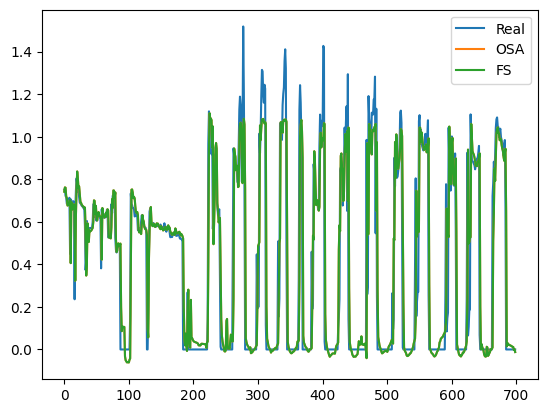

In [77]:
fig, ax = plt.subplots()
ax.plot(Y_real, label='Real')
ax.plot(Y_pred_OSA, label='OSA')
ax.plot(Y_pred_FS, label='FS')
ax.legend()

In [78]:
evaluator = Evaluator()
Y_real, Y_pred_OSA = evaluator.evaluate_OSA(dataset, best_model)
Y_real, Y_pred_FS = evaluator.evaluate_FS(dataset, best_model)

100%|██████████| 699/699 [00:01<00:00, 564.31it/s]


********** OSA Evaluation summary **********
OSA MSE: 0.03923852741718292
OSA RMSE: 0.1980871707201004
OSA R2 score: 0.7748092173650944
********************************************


100%|██████████| 699/699 [00:01<00:00, 524.75it/s]

*********** FS Evaluation summary **********
FS MSE: 0.03923852741718292
FS RMSE: 0.1980871707201004
FS R2 score: 0.7748092173650944
********************************************


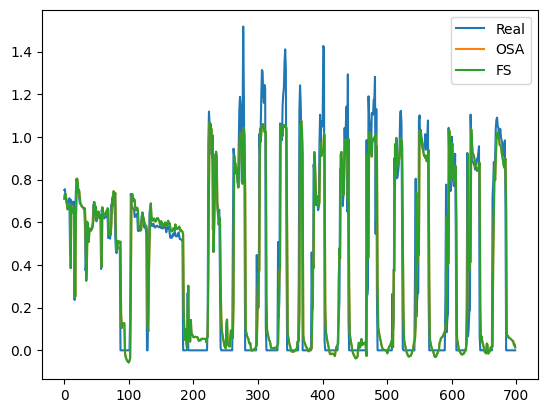

In [79]:
fig, ax = plt.subplots()
ax.plot(Y_real, label='Real')
ax.plot(Y_pred_OSA, label='OSA')
ax.plot(Y_pred_FS, label='FS')
ax.legend()